# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it. I look at used cars below.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

In [ ]:
header2 = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url2 = 'https://charlottesville.craigslist.org/search/bia#search=1~gallery~0~0'
raw2 = requests.get(url2,headers=header2) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 2. Get your search results of interest and extract data from them, using code similar to what's below.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [ ]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

In [ ]:
bsObj2 = soup(raw2.content,'html.parser') # Parse the html
listings2 = bsObj2.find_all(class_="cl-static-search-result") # Find all listings

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [ ]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

In [ ]:
brands2=['trek','schwinn','fuji','pivot','specialized','giant','norco','jetson']
data2 = [] # We'll save our listings in this object
for k in range(len(listings2)):
    title = listings2[k].find('div',class_='title').get_text().lower()
    price = listings2[k].find('div',class_='price').get_text()
    link = listings2[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands2] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data2.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [ ]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(91, 6)


,title,price,year,link,brand,age
0,2008 saab convertible,5800,2008.0,https://charlottesville.craigslist.org/cto/d/c...,missing,17.0
1,2003 honda pilot,6000,2003.0,https://charlottesville.craigslist.org/cto/d/w...,honda,22.0
2,09 camry le,3950,NaN,https://charlottesville.craigslist.org/cto/d/m...,missing,NaN
3,2016 bmw x3 xdrive35i,17500,2016.0,https://charlottesville.craigslist.org/cto/d/s...,bmw,9.0
4,ford truck,4000,NaN,https://charlottesville.craigslist.org/cto/d/w...,ford,NaN


In [ ]:
df2 = pd.DataFrame.from_dict(data2)
df2['price'] = df2['price'].str.replace('$','')
df2['price'] = df2['price'].str.replace(',','')
df2['price'] = pd.to_numeric(df2['price'],errors='coerce')
df2['year'] = pd.to_numeric(df2['year'],errors='coerce')
df2['age'] = 2025-df2['year']
print(df2.shape)
df2.to_csv('craigslist_cville_bikes.csv') # Save data in case of a disaster
df2.head()

(36, 6)


,title,price,year,link,brand,age
0,schwinn frontier 17 inch boys mountain bicycle,75,NaN,https://charlottesville.craigslist.org/bik/d/p...,schwinn,NaN
1,bicycles,25,NaN,https://charlottesville.craigslist.org/bik/d/b...,missing,NaN
2,pinarello maglianera,1800,NaN,https://charlottesville.craigslist.org/bik/d/c...,missing,NaN
3,unisex bicycle,55,NaN,https://charlottesville.craigslist.org/bik/d/p...,missing,NaN
4,trek wasabi alpha custom single speed pink wom...,300,NaN,https://charlottesville.craigslist.org/bik/d/n...,trek,NaN


With the data in and wrangled, we can now do EDA:

count       91.000000
mean      9208.659341
std       9695.085713
min       1000.000000
25%       3700.000000
50%       6000.000000
75%      10500.000000
max      55000.000000
Name: price, dtype: float64


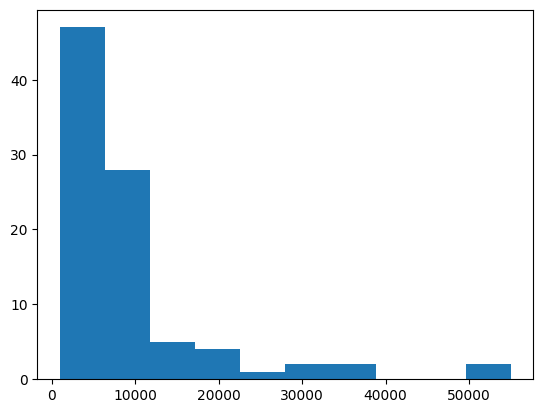

count    77.000000
mean     24.883117
std      18.236728
min       6.000000
25%      12.000000
50%      19.000000
75%      33.000000
max      94.000000
Name: age, dtype: float64


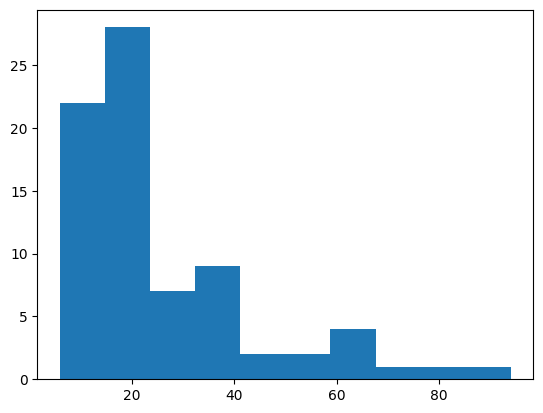

In [ ]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
bmw          4.0  16750.000000  14505.745988   6000.0   6375.0  12000.0   
buick        1.0   1000.000000           NaN   1000.0   1000.0   1000.0   
cadillac     1.0   2500.000000           NaN   2500.0   2500.0   2500.0   
chevrolet    3.0   7833.333333   6658.328118   3500.0   4000.0   4500.0   
chevy        2.0   5000.000000   4949.747468   1500.0   3250.0   5000.0   
dodge        5.0   8200.000000   3502.855978   3000.0   6300.0   9700.0   
ford        12.0  11000.000000  14252.655255   1500.0   4750.0   7550.0   
gmc          2.0   8800.000000   2404.163056   7100.0   7950.0   8800.0   
honda       10.0   5500.000000   2566.991321   2300.0   3887.5   5300.0   
infiniti     1.0   5800.000000           NaN   5800.0   5800.0   5800.0   
jeep         1.0   1500.000000           NaN   1500.0   1500.0   1500.0   
kia          2.0   5200.000000   2828.427125   3200.0   4200.0   5200.0   
lexus        1.0  10950.000000           NaN  10950.0  10950.0  10950.0   
mazda        1.0  23900.000000           NaN  23900.0  23900.0  23900.0   
missing     30.0  10733.100000  11157.885349   1500.0   3762.5   6150.0   
subaru       2.0   3700.000000    282.842712   3500.0   3600.0   3700.0   
tesla        1.0  16900.000000           NaN  16900.0  16900.0  16900.0   
toyota       8.0   8643.125000   9129.267275   3000.0   3462.5   4450.0   
volkswagen   1.0   7500.000000           NaN   7500.0   7500.0   7500.0   
volvo        3.0   4300.000000   2515.949125   2700.0   2850.0   3000.0   

                               
                 75%      max  
brand                          
bmw         22375.00  37000.0  
buick        1000.00   1000.0  
cadillac     2500.00   2500.0  
chevrolet   10000.00  15500.0  
chevy        6750.00   8500.0  
dodge       10500.00  11500.0  
ford        10225.00  55000.0  
gmc          9650.00  10500.0  
honda        7125.00   9950.0  
infiniti     5800.00   5800.0  
jeep         1500.00   1500.0  
kia          6200.00   7200.0  
lexus       10950.00  10950.0  
mazda       23900.00  23900.0  
missing     12525.00  51999.0  
subaru       3800.00   3900.0  
tesla       16900.00  16900.0  
toyota       9848.75  30000.0  
volkswagen   7500.00   7500.0  
volvo        5100.00   7200.0

In [ ]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
bmw          2.0  13.500000   6.363961   9.0  11.25  13.5  15.75  18.0
buick        1.0  62.000000        NaN  62.0  62.00  62.0  62.00  62.0
cadillac     1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0
chevrolet    3.0  37.000000   1.732051  36.0  36.00  36.0  37.50  39.0
chevy        2.0  15.000000   9.899495   8.0  11.50  15.0  18.50  22.0
dodge        3.0  31.000000  17.320508  21.0  21.00  21.0  36.00  51.0
ford         9.0  26.888889  26.506813   9.0  10.00  22.0  25.00  94.0
gmc          2.0  19.000000  11.313708  11.0  15.00  19.0  23.00  27.0
honda       10.0  20.100000   7.978443  10.0  14.25  18.5  22.75  33.0
infiniti     1.0  16.000000        NaN  16.0  16.00  16.0  16.00  16.0
jeep         0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
kia          2.0  13.500000   6.363961   9.0  11.25  13.5  15.75  18.0
lexus        1.0  13.000000        NaN  13.0  13.00  13.0  13.00  13.0
mazda        1.0   6.000000        NaN   6.0   6.00   6.0   6.00   6.0
missing     24.0  29.125000  23.007206   6.0  11.00  18.0  48.00  79.0
subaru       2.0  17.500000   0.707107  17.0  17.25  17.5  17.75  18.0
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0
toyota       8.0  21.375000  11.855529   7.0  14.25  19.0  27.50  41.0
volkswagen   1.0  44.000000        NaN  44.0  44.00  44.0  44.00  44.0
volvo        3.0  25.000000   6.928203  21.0  21.00  21.0  27.00  33.0

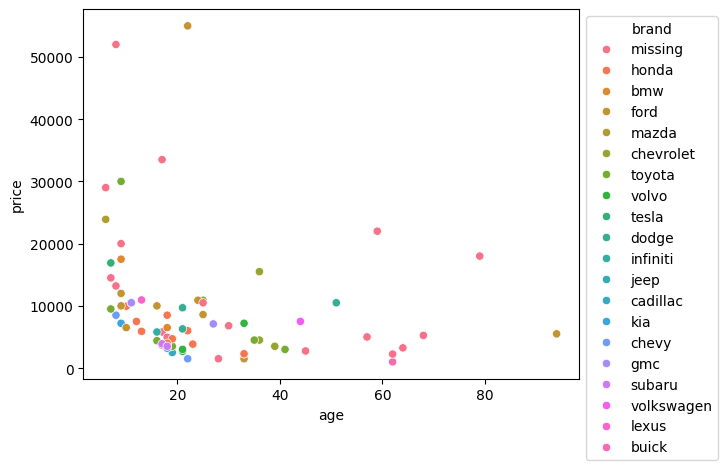

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

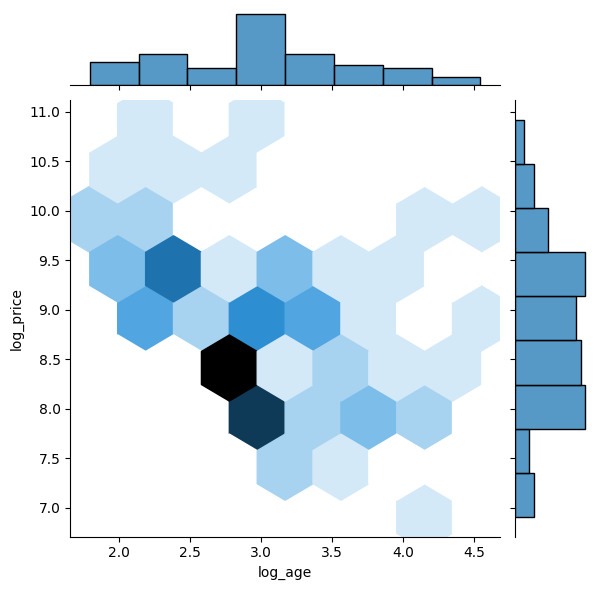

In [ ]:
sns.jointplot(data=df, x='log_age', y='log_price',kind='hex')

count      36.000000
mean     1104.305556
std      1469.728912
min         0.000000
25%       100.000000
50%       437.500000
75%      1243.750000
max      5700.000000
Name: price, dtype: float64


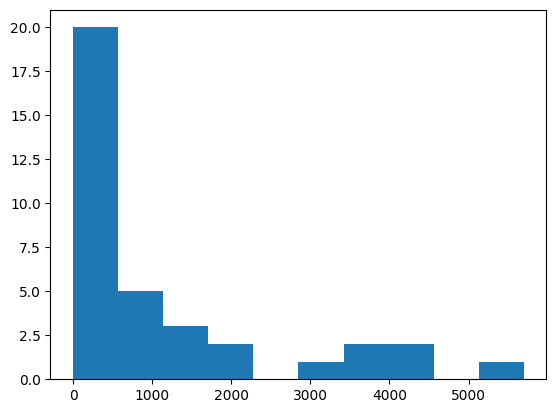

count     9.000000
mean      7.888889
std       9.293068
min       2.000000
25%       4.000000
50%       4.000000
75%       7.000000
max      32.000000
Name: age, dtype: float64


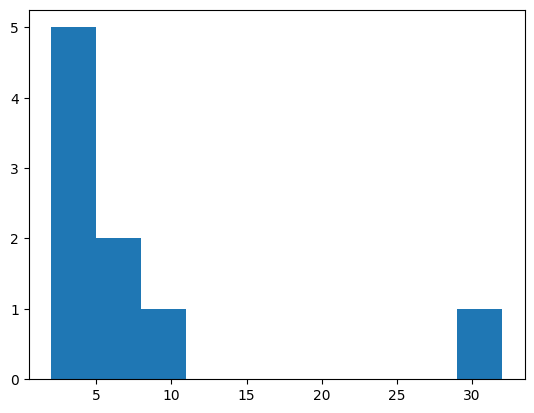

In [ ]:
print(df2['price'].describe())
df2['price'].hist(grid=False)
plt.show()
print(df2['age'].describe())
df2['age'].hist(grid=False)
plt.show()

In [ ]:
df2.loc[:,['price','brand']].groupby('brand').describe()

price                                                              \
            count         mean          std     min      25%     50%      75%   
brand                                                                           
fuji          1.0   100.000000          NaN   100.0   100.00   100.0   100.00   
giant         2.0  3750.000000   353.553391  3500.0  3625.00  3750.0  3875.00   
jetson        1.0   400.000000          NaN   400.0   400.00   400.0   400.00   
missing      22.0  1010.681818  1522.603734     0.0    62.50   287.5  1150.00   
norco         1.0  1375.000000          NaN  1375.0  1375.00  1375.0  1375.00   
pivot         1.0  3600.000000          NaN  3600.0  3600.00  3600.0  3600.00   
schwinn       2.0   287.500000   300.520382    75.0   181.25   287.5   393.75   
specialized   2.0  1220.000000  1053.589104   475.0   847.50  1220.0  1592.50   
trek          4.0   382.500000   223.364426   180.0   270.00   325.0   437.50   

                     
                max  
brand                
fuji          100.0  
giant        4000.0  
jetson        400.0  
missing      5700.0  
norco        1375.0  
pivot        3600.0  
schwinn       500.0  
specialized  1965.0  
trek          700.0

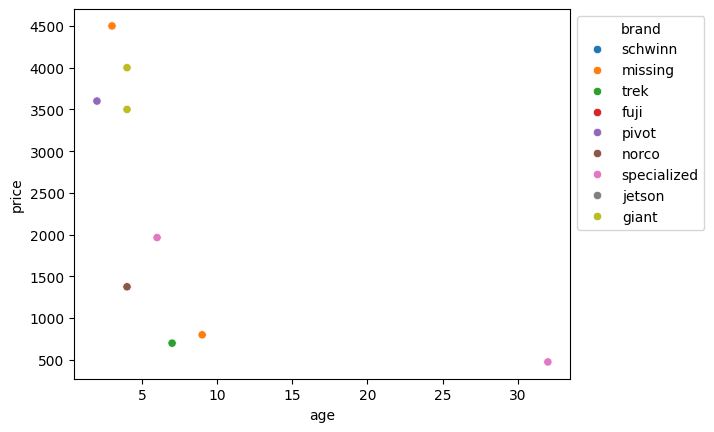

In [ ]:
ax = sns.scatterplot(data=df2, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price   log_age
log_price   2.414856 -0.575277
log_age    -0.575277  0.638039
           log_price   log_age
log_price   1.000000 -0.845815
log_age    -0.845815  1.000000


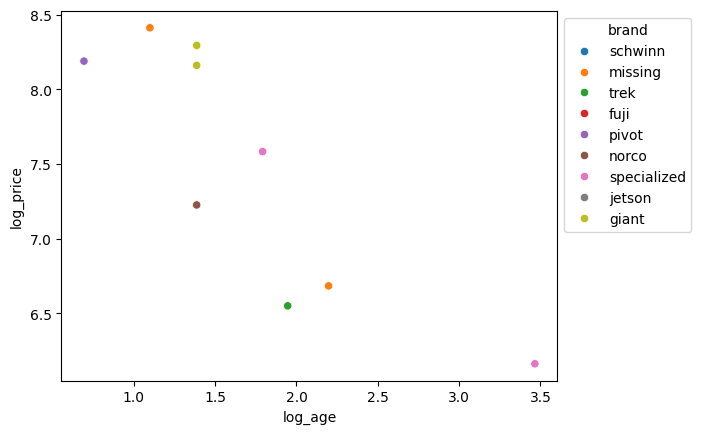

In [22]:
df2['log_price'] = np.log(df2['price'])
df2['log_age'] = np.log(df2['age'])

ax = sns.scatterplot(data=df2, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df2.loc[:,['log_price','log_age']].cov())
print(df2.loc[:,['log_price','log_age']].corr())

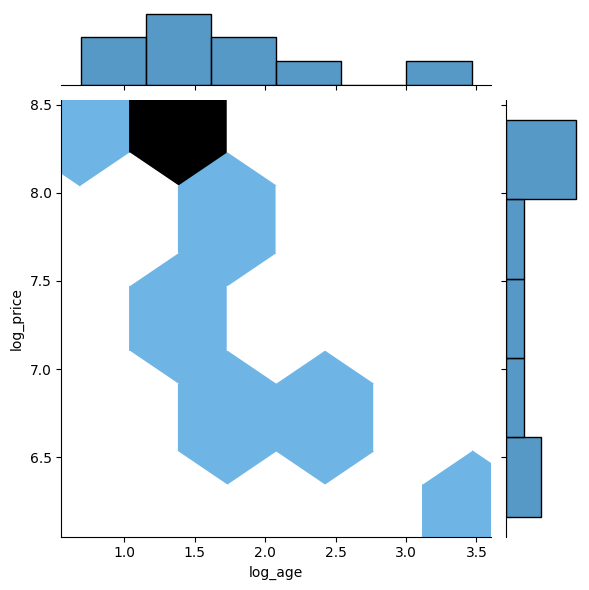

In [24]:
sns.jointplot(data=df2, x='log_age', y='log_price',kind='hex')

## 4. (Optional) From your search results, crawl to the links and extract more information about every listing in your original dataframe. Wrangle and do some EDA.

The final thing we want to do is go from scraping a single page to crawling around.

The idea here is that every web page is connected to some other page. By extracting links as we move from page to page, we can create a web crawler that wanders around for us, gathering information of interest.

In this case, we want to use the search results to then visit each individual page for each listing. Since we saved the links to the web pages in the previous scrape, we can now simply for-loop over that column in the dataframe, visiting the page listing for each of the cars in the search results:

In [25]:
import time # Time delays
import random # Random numbers

links = df['link']
data = []
for link in links: # about 3 minutes
    time.sleep(random.randint(1, 3)) # Random delays
    raw = requests.get(link,headers=header) # Get page
    bsObj = soup(raw.content,'html.parser') # Parse the html
    #
    try:
        year_post = bsObj.find(class_='attr important').find(class_ = 'valu year').get_text()
    except:
        year_post = np.nan
    #
    try:
        condition = bsObj.find(class_='attr condition').find(href=True).get_text()
    except:
        condition = 'missing'
    #
    try:
        cylinders = bsObj.find(class_='attr auto_cylinders').find(class_ = 'valu').get_text()
        cylinders = cylinders.replace('\n','')
    except:
        cylinders = 'missing'
    #
    try:
        drivetrain = bsObj.find(class_='attr auto_drivetrain').find(href=True).get_text()
    except:
        drivetrain = 'missing'
    #
    try:
        fuel = bsObj.find(class_='attr auto_fuel_type').find(href = True).get_text()
    except:
        fuel = 'missing'
    #
    try:
        miles = bsObj.find(class_='attr auto_miles').find(class_ = 'valu').get_text()
    except:
        miles = np.nan
    #
    try:
        color = bsObj.find(class_='attr auto_paint').find(href=True).get_text()
    except:
        color='missing'
    #
    try:
        title = bsObj.find(class_='attr auto_title_status').find(href=True).get_text()
    except:
        title='missing'
    #
    try:
        transmission = bsObj.find(class_='attr auto_transmission').find(href=True).get_text()
    except:
        transmission = 'missing'
    #
    try:
        bodytype = bsObj.find(class_='attr auto_bodytype').find(href=True).get_text()
    except:
        bodytype = 'missing'
    #
    text = bsObj.find(id='postingbody').get_text()
    text = text.replace('\n','')
    text = text.replace('QR Code Link to This Post','')
    record = {'title':title,
              'year_post':year_post,
              'condition':condition,
              'cylinders':cylinders,
              'drivetrain':drivetrain,
              'fuel':fuel,
              'miles':miles,
              'color':color,
              'title':'title',
              'transmission':transmission,
              'bodytype':bodytype,
              'text':text,}
    data.append(record)

What are the new features here?

First, we don't want to overwhelm the servers, so we put a small delay between each request of a listing, `time.sleep(random.randint(1, 3))`. This waits a random amount of time between 1 and 3 seconds to avoid overwhelming their server.

Second, we use the try/except block. This is a useful control structure in general, but especially for web scraping. Python tries the statements under `try:`, and if it fails, executes the steps under `except:`. This can happen, in this case, with missing data, which crashes the crawler. Instead, we put our missing codes into our dataframe right away.

Third, we used `.find().find().get_text()` to find the data we're looking for. In general, the structure of mark-up langauges like HTML and XML makes it possible to "drill down" into their entries and extract the information of interest. This exploitation of mark-up languages could be the subject of a whole course on procuring data from the web.

With the data scraped, we can make a new dataframe, combine it with the old one using `pd.concat`, and do some wrangling to clean the data up:

In [26]:
new_df = pd.DataFrame.from_dict(data)
new_df.head()

df = pd.concat([df,new_df],axis=1) # combine data frames
df.head()

df['miles'] = df['miles'].str.replace(',','')
df['miles'] = pd.to_numeric(df['miles'],errors='coerce')

df['year_post'] = df['year_post'].str.replace(',','')
df['year_post'] = pd.to_numeric(df['year_post'],errors='coerce')
df.to_csv('craiglist_cville_cars_long.csv')